In [1]:
# import libraries

import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# read data

df = pd.read_csv("C:/Users/bonfa/Downloads/Reviews.csv/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# 1 for positive review, 0 for negative review
df.loc[df.Score > 3, 'Label_G1'] = 1
df.loc[df.Score < 3, 'Label_G1'] = 0

# 1 for positive review, 0 for negative review
df.loc[df.Score == 5, 'Label_G2'] = 1
df.loc[df.Score == 1, 'Label_G2'] = 0

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Label_G1,Label_G2
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,NaN
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.0,NaN
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1.0,1.0


In [5]:
# drop rows without label
def dropnull(dataframe, subset_list):
    """drop the rows when values in the columns listed in subset are null and reset index"""
    new_df = dataframe.copy().dropna(subset = subset_list)
    new_df.reset_index(drop = True, inplace = True)
    
    return new_df

In [6]:
# drop null value in the column, 'Label'
df_g1 = dropnull(df, ['Label_G1'])
df_g2 = dropnull(df, ['Label_G2'])

In [7]:
# leave the label column applicable for data group
df_g1.drop(columns = ['Label_G2'], inplace = True)
df_g2.drop(columns = ['Label_G1'], inplace = True)

Value Counts of  Label_G1


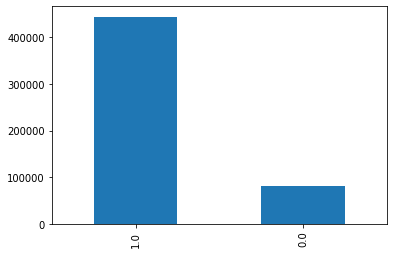

Value Counts of  Label_G2


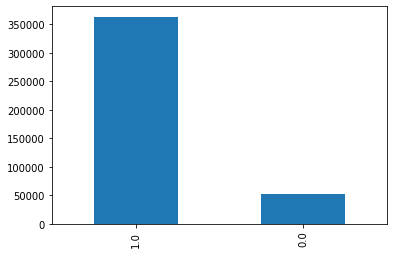

In [8]:
# check the value counts of each label groups
for i, d, c in zip([0,1], [df_g1, df_g2],['Label_G1', 'Label_G2']):
    reviews_count = d[c].value_counts()
    print("Value Counts of ", c)
    
    reviews_count.plot(kind = 'bar')
    plt.show()

Majority of reviews are positive in both dataframes and the total number of data is rougly over 400,000 each.

In [9]:
# randomly select 10,000 reviews each for positive and negative reviews
def sampled_df(data, label_column, sample_size):
    unique_val = data[label_column].unique()
    
    np.random.seed(9)
    def sampling(data, label_val):
        all_index = data[data[label_column] == label_val].index
        sample_index = np.random.choice(all_index, size = sample_size, replace = False)
        sample_df = data.loc[sample_index]
        sample_df.reset_index(drop = True, inplace = True)
        
        return sample_df
    
    label_df_list = []
    for v in unique_val:
        label_df = sampling(data, v)
        label_df_list.append(label_df)
        
    reviews = pd.concat(label_df_list, ignore_index = True)
    
    return reviews


In [10]:
# create dataframe of sample for two label group
sample_g1 = sampled_df(df_g1, 'Label_G1', 10000) # score > 3 positive review, score < 3 negative review
sample_g2 = sampled_df(df_g2, 'Label_G2', 10000) # score = 5 positive review, score = 1 negative review

In [11]:
# make a class to tokenize a review, select only alphabetical letters, and lemmatize tokenized words.  
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t.isalpha()]

In [12]:
# build the function which create a bag of words using CountVectorizer
def create_CV(data, text_column, max_features_n, ngram, stopwords):
    
    vect = CountVectorizer(tokenizer = LemmaTokenizer(), max_features = max_features_n, ngram_range = ngram, stop_words = 
                           stopwords)

    # fit the vectorizer
    vect.fit(data[text_column])

    # transform the review column
    CV = vect.transform(data.Text)

    return CV

In [13]:
# create a BOW with sample group 1
# the number of max feature: 100 words
CV_g1 = create_CV(sample_g1, 'Text', 100, (1,2), ENGLISH_STOP_WORDS)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [14]:
# according to error message, add some more stop words
my_stop_words = ENGLISH_STOP_WORDS.union(['ha', 'le', 'u', 'wa'])

In [15]:
# create again with the updated stop words
CV_g1 = create_CV(sample_g1, 'Text', 100, (1,2), my_stop_words)

In [16]:
def create_tfidf(data, text_column, max_features_n, ngram, stopwords):
# build the vectorizer, specify max_features
    vect2 = TfidfVectorizer(tokenizer = LemmaTokenizer(), max_features = max_features_n, ngram_range = ngram, stop_words =
                            stopwords)

    # fit the vectorizer
    vect2.fit(data[text_column])

    # transform the review column
    TF = vect2.transform(data[text_column])

    return TF

In [17]:
# create a tfidf with sample group 1
# the number of max feature: 100 words
TF_g1 = create_tfidf(sample_g1, 'Text', 100, (1,2), my_stop_words)

In [18]:
# create a function, modeling to train and test model and obtain accuracy score.
def modeling(X, y, testsize, c_n):
    
    # Perform the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = 9, stratify = y)

    # train logistic regression model
    log_reg = LogisticRegression(C = c_n).fit(X_train, y_train)

    # make prediction on the test set
    y_predicted = log_reg.predict(X_test)

    # save the performance metrics
    AccuracyScore = accuracy_score(y_test, y_predicted)
    ConfusionMatrix = confusion_matrix(y_test, y_predicted)/len(y_test)
    return log_reg, AccuracyScore, ConfusionMatrix

In [19]:
# save sample 1's label values in variable y1
y1 = sample_g1.Label_G1

In [20]:
# save the result
CV_model, CV_acc, CV_conf = modeling(CV_g1, y1, 0.3, 1)
TF_model, TF_acc, TF_conf = modeling(TF_g1, y1, 0.3, 1)

# compare the accuracy
print("Model Accuracy Score (CountVectorizer): ", CV_acc, '\n')
print("Model Accuracy Score (Tfidf): ", TF_acc)

Model Accuracy Score (CountVectorizer):  0.7421666666666666 

Model Accuracy Score (Tfidf):  0.7398333333333333


The classier trained with the matrix from CountVectorizer performs slightly better with higher accuracy score. Moreover, Tfidf consumes more memory and time than CounterVectorizer does. Therefore, I will select a matrix of CountVectorizer for the modeling. 

In [23]:
# find the best accuracy score by max_feature numbers
max_features_list = np.linspace(100, 1000, 10, dtype = int)

In [24]:
# iterate max_features_list and build the model 
model_list = []
for max_f in max_features_list:
    CV = create_CV(sample_g1, 'Text', max_f, (1,2), my_stop_words)
    model, accuracy, confusion = modeling(CV, y1, testsize = 0.3, c_n = 1)
    model_list.append(accuracy)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer

In [27]:
import joblib

filename = 'g1_max_f_result.sav'
joblib.dump(model_list, filename)


['g1_max_f_result.sav']

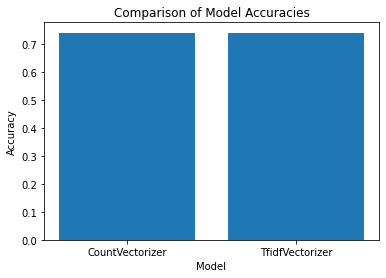

In [28]:


import matplotlib.pyplot as plt

# set the data
model_names = ['CountVectorizer', 'TfidfVectorizer']
accuracies = [CV_acc, TF_acc]

# create the bar chart
plt.bar(model_names, accuracies)

# set the labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')

# display the chart
plt.show()


The plot shows the accuracy from max features, 600 begins to stay constant. As the number over 600 doesn't contribute to significant accuracy improvement, I will consider 600 as an optimum number for max features. 

In [50]:
# save sample 2's label values in variable y2
y2 = sample_g2.Label_G2

In [60]:
model_list

[0.7421666666666666,
 0.7858333333333334,
 0.8053333333333333,
 0.8161666666666667,
 0.8271666666666667,
 0.8385,
 0.8415,
 0.8466666666666667,
 0.8471666666666666,
 0.8465]

In [62]:
print("Accuracy of model trained with max feature 1000:", model_list[-1])
print("Accuracy of model trained on sample group 2:", accuracy)

Accuracy of model trained with max feature 1000: 0.8465
Accuracy of model trained on sample group 2: 0.8701666666666666
